# Imports, Custom Functions & Data Loading

## Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import spacy 

from collections import Counter, defaultdict

from transformers import AutoTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification, BertTokenizer, BertForSequenceClassification, \
                         RobertaTokenizer, RobertaForSequenceClassification, AutoModel, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

from transformers import AutoModelForSequenceClassification

from tokenizers import ByteLevelBPETokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from tqdm import tqdm

from sklearn.metrics import f1_score

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

# Ignore RuntimeWarning and UserWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Define functions

In [5]:
def preprocess(text):
    
    # remove URLs
    text = re.sub('http\S*', ' ', text)
    
    # remove non-alphabetic
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # make lowercase
    text = text.lower()

    # remove one character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    
    # replace double space to one space
    text = re.sub("\s+", ' ', text)
    
    # tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


def train_BPE_tokenizer(train_text_df, text_column, vocab_size=5000, min_frequency=2):
    # Extract the text from the specified column
    texts = train_text_df[text_column].tolist()

    # Initialize a BPE tokenizer
    tokenizer = ByteLevelBPETokenizer()

    # Train the BPE tokenizer on the text
    tokenizer.train_from_iterator(texts, vocab_size=vocab_size, min_frequency=min_frequency)

    # Tokenize the text in the DataFrame and remove "Ġ" character
    train_text_df[text_column + '_tokenized'] = train_text_df[text_column].apply(lambda x: [token.replace("Ġ", "") for token in tokenizer.encode(x).tokens])

    return tokenizer


def tokenize_text(tokenizer, df, text_column):
    # Extract the text from the specified column
    texts = df[text_column].tolist()

    # Tokenize the text in the DataFrame using the pre-trained tokenizer and remove "Ġ" character
    df[text_column + '_tokenized'] = [[token.replace("Ġ", "") for token in tokenizer.encode(text).tokens] for text in texts]


class BPE():
    """Byte-Pair Encoding: Subword-based tokenization algorithm."""
    
    def __init__(self, corpus, vocab_size):
        """Initialize BPE tokenizer."""
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # pre-tokenize the corpus into words, BERT pre-tokenizer is used here
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        """Train BPE tokenizer."""
    # (1) Compute the frequencies of each word in the corpus
    # (2) Compute the base vocabulary of all characters in the corpus
    # (3) Split each word into individual characters before training
    # (4) Merge the most frequent pair iteratively until the vocabulary size is reached

        # compute the frequencies of each word in the corpus
        for text in self.corpus:
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        # compute the base vocabulary of all characters in the corpus
        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # add the special token </w> at the beginning of the vocabulary
        vocab = ["</w>"] + alphabet.copy()

        # split each word into individual characters before training
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # merge the most frequent pair iteratively until the vocabulary size is reached
        while len(vocab) < self.vocab_size:

            # compute the frequency of each pair
            pair_freqs = self.compute_pair_freqs()

            # find the most frequent pair
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # merge the most frequent pair
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """Compute the frequency of each pair."""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """Merge the given pair."""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):
        """Tokenize a given text with trained BPE tokenizer (including pre-tokenization, split, and merge)."""
        
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result
    

def get_tfidf_matrix(df, vectorizer):
    
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()

    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


# The sequences being in the formar ['word1', 'word2', 'word3', ...], preprocess it
def string2embedding_idx(text_sequence, model):

    sequence = []
    for token in text_sequence:
        try:
            sequence.append(model.wv.key_to_index[token])
        except:
            sequence.append(2899)

    return sequence


def TSNE_10ClosestWords(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0, perplexity = 10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    

class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sequence_tensor, label_tensor


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def TokenizeBERT(tokenizer, df, batch_size = 32, shuffle = True):
    # Tokenize training data
    encodings = tokenizer(df['clean_text'].tolist(), add_special_tokens = True, truncation = True, padding = True, return_tensors = "pt")

    # Convert labels to PyTorch tensors
    labels = torch.tensor(df['target'].tolist())

    # Create a DataLoader for training data
    dataset = torch.utils.data.TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)

    return dataset, dataloader


def TokenizeBERTweet(tokenizer, df, batch_size = 32, shuffle = True, tokenizer_normalizeTweet = None):

    # Normalize the text
    if tokenizer_normalizeTweet is not None:
        normalized_tweets = df['text'].apply(lambda x: tokenizer_normalizeTweet.normalizeTweet(x))
    else:
        normalized_tweets = df['text'].apply(lambda x: tokenizer.normalizeTweet(x))

    # Tokenize training data
    encodings = tokenizer(normalized_tweets.tolist(), add_special_tokens = True, truncation = True, padding = True, return_tensors = "pt")

    # Convert labels to PyTorch tensors
    labels = torch.tensor(df['target'].tolist())

    # Create a DataLoader for training data
    dataset = torch.utils.data.TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)

    return dataset, dataloader


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (output > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, (data, target) in pbar:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = loss_fn(output, target)

                test_loss += loss.item()

                predicted = (output > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


def train_BERT(model, train_loader, test_loader, optimizer, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].to(device)
            model.zero_grad()
            output = model(input_ids, attention_mask=attn_mask, labels=target)
            logits = output.logits.squeeze(-1)

            loss = output.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(logits.data, 1)
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, data in pbar:
                input_ids = data[0].to(device)
                attn_mask = data[1].to(device)
                target = data[2].to(device)
                model.zero_grad()
                output = model(input_ids, attention_mask=attn_mask, labels=target)
                logits = output.logits.squeeze(-1)

                loss = output.loss
                test_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


def train_BERTweet(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_func', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, data in pbar:
            input_ids = data[0].to(device)
            attn_mask = data[1].to(device)
            target = data[2].float().unsqueeze(1).to(device)
            model.zero_grad()
            logits = model(input_ids, attention_mask=attn_mask)

            loss = loss_fn(logits, target)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            predicted = (logits > 0.0).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, data in pbar:
                input_ids = data[0].to(device)
                attn_mask = data[1].to(device)
                target = data[2].float().unsqueeze(1).to(device)
                model.zero_grad()
                logits = model(input_ids, attention_mask=attn_mask)

                loss = loss_fn(logits, target)
                test_loss += loss.item()

                predicted = (logits > 0.0).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst


# LSTM model with pre-trained Word2Vec embeddings
class CustomLSTM(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output


# GRU model with pre-trained Word2Vec embeddings
class CustomGRU(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output


class Attention(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = torch.nn.Linear(hidden_dim, 1)


    def forward(self, output):
        # lstm_output = [batch size, seq_len, hidden_dim]
        attention_scores = self.attn(output)

        return torch.nn.functional.softmax(attention_scores, dim=1)



# GRU model with pre-trained Word2Vec embeddings and attention mechanism
class CustomGRU_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output


# LSTM model with pre-trained Word2Vec embeddings and attention mechanism
class CustomLSTM_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.attention = Attention(hidden_size * (2 if bidirectional else 1))
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # Get the embedding of each token in the sequence
        x = self.embedding(x)
        # Apply LSTM to the sequence of embeddings
        output, _ = self.lstm(x)
        # Apply the attention mechanism and get attention weights
        attn_weights = self.attention(output)
        # Compute the weighted sum of the hidden states
        output = torch.sum(attn_weights * output, dim = 1)
        # Compute the logits
        logits = self.fc(output)

        return logits
    

# LSTM model with pre-trained Word2Vec embeddings and multi-head attention mechanism
class CustomLSTM_MultiHeadAttention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, dropout=0.1, num_layers=1, bidirectional=False, freeze_embeddings=True, num_heads=8):
        super(CustomLSTM_MultiHeadAttention, self).__init__()

        # Word embedding layer
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)

        # LSTM layer
        self.sequence_size = 49
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Multi-Head Attention layer
        self.multihead_attention = torch.nn.MultiheadAttention(embed_dim=hidden_size * (2 if bidirectional else 1), num_heads=num_heads, dropout=dropout, batch_first=True)

        # Fully-connected layers for classification head
        self.fc1 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1) * self.sequence_size, hidden_size * (2 if bidirectional else 1))
        self.fc2 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(hidden_size * (2 if bidirectional else 1))
        self.classification_head = torch.nn.Sequential(self.fc1, self.relu, self.bn, self.dropout, self.fc2)

        # Initialize the weights with the kaiming uniform initialization
        for layer in self.classification_head:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity = 'relu')

        # Initialize the weights with the kaiming uniform initialization for the multi-head attention
        torch.nn.init.kaiming_uniform_(self.multihead_attention.in_proj_weight, nonlinearity = 'relu')

        # Initialize the weights with the kaiming uniform initialization for the LSTM
        for layer in self.lstm._all_weights:
            for param_name in layer:
                if 'weight' in param_name:
                    torch.nn.init.kaiming_uniform_(getattr(self.lstm, param_name), nonlinearity = 'relu')


    def forward(self, x):
        # Get the embedding of each token in the sequence
        embed = self.embedding(x)
        # Apply LSTM to the sequence of embeddings
        hx, cx = self.lstm(embed)
        # Apply multihead attention and get attention weights
        attn_output, attn_weights = self.multihead_attention(hx, hx, hx)
        # Flatten or pool the multihead attention outputs across the sequence dimension
        flattened_output = attn_output.reshape(attn_output.size(0), -1)
        # Compute the logits considering the weighted values (V) of the multihead attention
        logits = self.classification_head(flattened_output)

        return logits


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.positional_encoding = torch.zeros((1, max_len, d_model))
        self.positional_encoding[0, :, 0::2] = torch.sin(position * div_term)
        self.positional_encoding[0, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1), :]


class TransformerEncoder(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True):
        super(TransformerEncoder, self).__init__()

        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_len)
        
        self.transformer_encoder_layer = torch.nn.TransformerEncoderLayer(
                                                                          d_model=embedding_dim,
                                                                          nhead=num_heads,
                                                                          dim_feedforward=hidden_dim,
                                                                          dropout=dropout
                                                                          )
        self.transformer_encoder = torch.nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)  # Change from (batch_size, seq_len, embedding_dim) to (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embedding_dim)
        return x
    

class TransformerEncoderForClassification(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True, num_classes=1):
        super(TransformerEncoderForClassification, self).__init__()

        self.embedding_dim = embedding_dim
        self.encoder = TransformerEncoder(word2vec_model, num_heads, hidden_dim, num_layers, max_len, dropout, freeze_embeddings)
        
        # Classification head
        self.fc = torch.nn.Linear(self.embedding_dim, num_classes)

    def forward(self, x):
        encoder_output = self.encoder(x)
        
        # Global average pooling along the sequence dimension
        pooled_output = torch.nn.functional.adaptive_avg_pool1d(encoder_output.permute(0, 2, 1), 1).squeeze(-1)
        
        # Classification head
        logits = self.fc(pooled_output)

        return logits
    

# FCNN model to be used with the TF-IDF features
class CustomFCNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.1):
        super(CustomFCNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.outlayer = torch.nn.Linear(hidden_size, 1)

        self.relu = torch.nn.ReLU()

        self.bn = torch.nn.BatchNorm1d(hidden_size)

        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.bn(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn(self.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn(self.relu(self.fc3(x)))
        x = self.dropout(x)
        logits = self.outlayer(x)

        return logits
    

class BERTweetForSequenceClassification(torch.nn.Module):
    def __init__(self, bertweet_model, hidden_size, output_size, dropout_rate = 0.1):
        super(BERTweetForSequenceClassification, self).__init__()

        self.bertweet_model = bertweet_model

        self.dropout = torch.nn.Dropout(dropout_rate)
        self.BatchNorm = torch.nn.BatchNorm1d(hidden_size)

        self.dense = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        # Apply batch normalization to the output of the BERTweet model
        output = self.BatchNorm(self.bertweet_model(input_ids, attention_mask).pooler_output)
        # Apply dropout
        output = self.dropout(output)
        # Apply the output layer
        logits = self.dense(output)

        return logits

## Data Loading

In [6]:
tweets_train = pd.read_csv('../data/tweets_data/train.csv')[['text', 'target']].reset_index(drop=True)
tweets_test = pd.read_csv('../data/tweets_data/test.csv')[['id', 'text']]
tweets_labels = pd.read_csv('../data/tweets_data/test_labels.csv', encoding='latin-1')[['choose_one', 'text']]

tweets_labels['target'] = (tweets_labels['choose_one']=='Relevant').astype(int)
tweets_labels['id'] = tweets_labels.index

tweets_test = pd.merge(left = tweets_test, right = tweets_labels, on='id', how = 'left')[['id', 'text_x', 'target']]
tweets_test.rename(columns={'text_x': 'text'}, inplace=True)
tweets_test = tweets_test[['text', 'target']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text,target
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


# Text pre-processing

## Cleaning text using key-words and lemmatization

In [7]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [8]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...



Testing data


,text,target,clean_text
0,Just happened a terrible car crash,1,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [9]:
# Train the BPE tokenizer on the training data
Tokenizer = train_BPE_tokenizer(train_text_df = tweets_train, text_column = 'clean_text', vocab_size = 20000, min_frequency = 1)

# Assuming Tokenizer is the pre-trained tokenizer from the training data
# Tokenize the test data using the pre-trained tokenizer
tokenize_text(tokenizer = Tokenizer, df = tweets_test, text_column = 'clean_text')

In [10]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[, people, receive, wildfire, evacuation, orde..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi..."



Testing data


,text,target,clean_text,clean_text_tokenized
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash]"
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]"
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, sp, okane, wildfire]"
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


In [11]:
'''# set the hyperparameter of vocabulary size
vocab_size = 3000
corpus = tweets_train['clean_text'].tolist()

# create a BPE tokenizer object
MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

# train BPE tokenizer with Wikipedia corpus
MyBPE.train()'''

"# set the hyperparameter of vocabulary size\nvocab_size = 3000\ncorpus = tweets_train['clean_text'].tolist()\n\n# create a BPE tokenizer object\nMyBPE = BPE(corpus=corpus, vocab_size=vocab_size)\n\n# train BPE tokenizer with Wikipedia corpus\nMyBPE.train()"

In [12]:
'''tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))
tweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))'''

"tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))\ntweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))"

## Convert Text into Input Features

### TF-IDF

In [13]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(tweets_train['clean_text_tokenized'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

X_test = vectorizer.transform(tweets_test['clean_text_tokenized'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [14]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, sask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[, people, receive, wildfire, evacuation, orde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,target,clean_text,clean_text_tokenized,TFIDF
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, sp, okane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [15]:
print('Maximum length of tokenized text in training data:', max([len(sent) for sent in tweets_train['clean_text_tokenized']]))
print('Maximum length of tokenized text in testing data:', max([len(sent) for sent in tweets_test['clean_text_tokenized']]))

Maximum length of tokenized text in training data: 26
Maximum length of tokenized text in testing data: 45


In [16]:
# Train Word2Vec model
cbow_model = Word2Vec(sentences = tweets_train['clean_text_tokenized'], vector_size = 1024, window = 5, min_count = 1, workers = 4, sg = 0, epochs = 256)
# Add the <pad> token to the cbow_model so that the last token is the <pad> token
cbow_model.wv.key_to_index['<pad>'] = len(cbow_model.wv)
# Add the embedding of <pad> token to the cbow_model
cbow_model.wv.vectors = np.append(cbow_model.wv.vectors, np.zeros((1, 1024)), axis=0)


skipgram_model = Word2Vec(sentences = tweets_train['clean_text_tokenized'], vector_size = 1024, window = 5, min_count = 1, workers = 4, sg = 1, epochs = 256)
# Add the <pad> token to the skipgram_model so that the last token is the <pad> token
skipgram_model.wv.key_to_index['<pad>'] = len(skipgram_model.wv)
# Add the embedding of <pad> token to the skipgram_model
skipgram_model.wv.vectors = np.append(skipgram_model.wv.vectors, np.zeros((1, 1024)), axis=0)

# Add the <pad> token to all the tokenized text until the length of each tokenized text is 50
tweets_train['clean_text_tokenized'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: tokens + ['<pad>'] * (45 - len(tokens)))
tweets_test['clean_text_tokenized'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: tokens + ['<pad>'] * (45 - len(tokens)))

# Apply the string2embedding_idx function to create a new column
tweets_train['CBOW_sequences'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_train['SkipGram_sequences'] = tweets_train['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))
tweets_test['CBOW_sequences'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_test['SkipGram_sequences'] = tweets_test['clean_text_tokenized'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))

In [17]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,clean_text_tokenized,TFIDF,CBOW_sequences,SkipGram_sequences
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive, <pa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3996, 461, 209, 1422, 2511, 13815, 13815, 138...","[3996, 461, 209, 1422, 2511, 13815, 13815, 138..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, sask, canada...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[120, 2, 176, 514, 2045, 1500, 6753, 1137, 138...","[120, 2, 176, 514, 2045, 1500, 6753, 1137, 138..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1679, 515, 1901, 382, 6750, 322, 205, 1901, 3...","[1679, 515, 1901, 382, 6750, 322, 205, 1901, 3..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[, people, receive, wildfire, evacuation, orde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 8, 2988, 84, 205, 292, 38, 13815, 13815, 1...","[0, 8, 2988, 84, 205, 292, 38, 13815, 13815, 1..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ruby, alaska, smoke, wildfi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[312, 207, 126, 6038, 1457, 217, 84, 3009, 125...","[312, 207, 126, 6038, 1457, 217, 84, 3009, 125..."



Testing data


,text,target,clean_text,clean_text_tokenized,TFIDF,CBOW_sequences,SkipGram_sequences
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, terrible, car, crash, <pad>, <pad>, <...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[201, 1920, 43, 16, 13815, 13815, 13815, 13815...","[201, 1920, 43, 16, 13815, 13815, 13815, 13815..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[141, 209, 1039, 122, 390, 1008, 13815, 13815,...","[141, 209, 1039, 122, 390, 1008, 13815, 13815,..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, pond, go, ose, flee, stre...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[120, 2, 580, 3275, 6, 2899, 2406, 431, 104, 1...","[120, 2, 580, 3275, 6, 2899, 2406, 431, 104, 1..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, lighting, sp, okane, wildfire, <p...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[373, 10784, 1663, 2899, 84, 13815, 13815, 138...","[373, 10784, 1663, 2899, 84, 13815, 13815, 138..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, <pad>...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[171, 539, 11, 268, 1021, 13815, 13815, 13815,...","[171, 539, 11, 268, 1021, 13815, 13815, 13815,..."


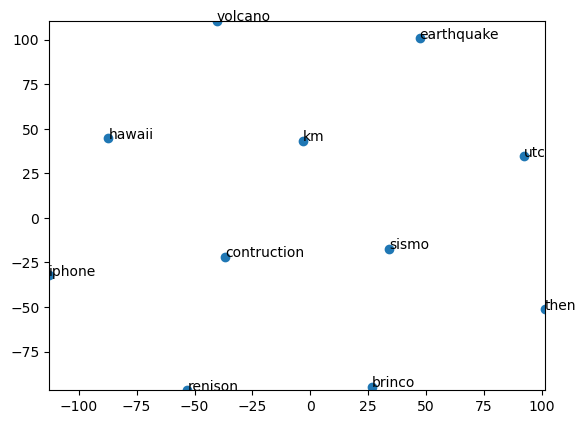

In [18]:
TSNE_10ClosestWords(cbow_model, 'earthquake', 1024)

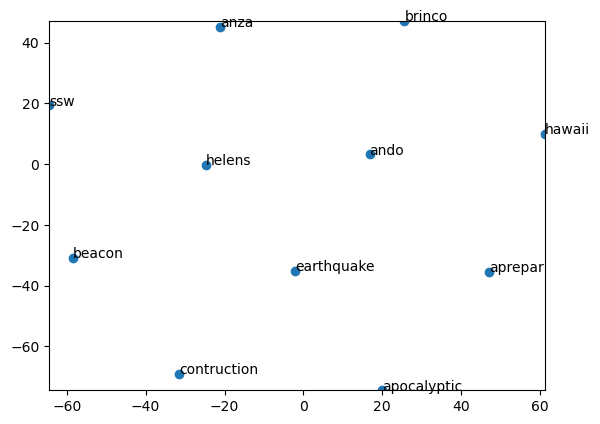

In [19]:
TSNE_10ClosestWords(skipgram_model, 'earthquake', 1024)

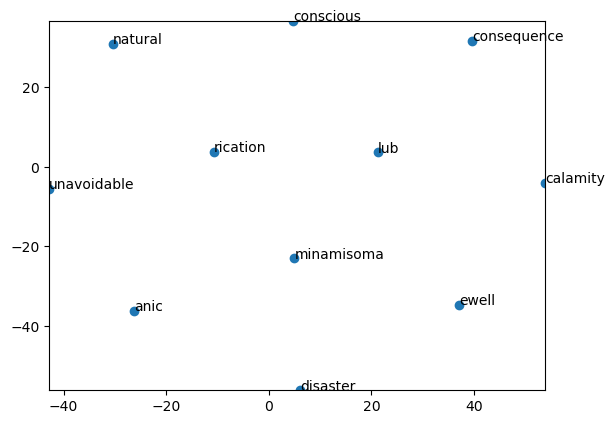

In [20]:
TSNE_10ClosestWords(cbow_model, 'disaster', 1024)

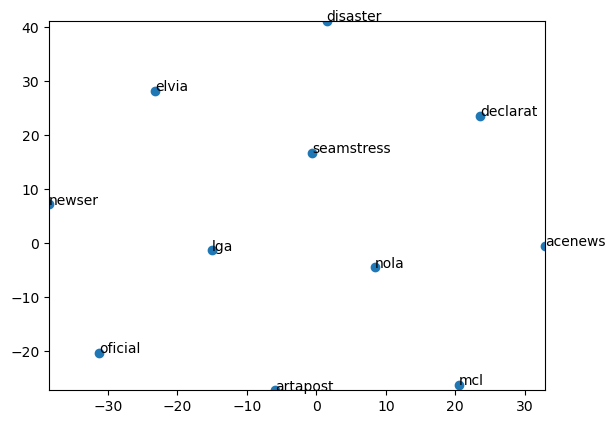

In [21]:
TSNE_10ClosestWords(skipgram_model, 'disaster', 1024)

# Loading and Testing our Pre-Trained Embeddings to the PyTorch's Embedding layer

In [19]:
# create embedding layer with pre-trained weights
pretrained_embeddings_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(skipgram_model.wv.vectors))
# check weights of the pre-trained embedding layer
pretrained_embeddings_layer.weight

Parameter containing:
tensor([[ 0.1773,  0.1768, -0.1317,  ..., -0.1484,  0.3132, -0.1420],
        [-0.2578,  0.0246, -0.3352,  ..., -0.2775,  0.0449,  0.2594],
        [-0.0917, -0.0222,  0.0112,  ..., -0.2537,  0.2060, -0.0622],
        ...,
        [-0.0177,  0.0844,  0.0200,  ..., -0.0068,  0.0031,  0.0847],
        [ 0.2132,  0.1367,  0.1521,  ..., -0.0835,  0.1972,  0.3232],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [20]:
TrainTweetsDataset = TweetsDataset(tweets_train, 'skipgram')
TrainTweetsDataset[0]

(tensor([ 3996,   461,   209,  1422,  2511, 13815, 13815, 13815, 13815, 13815,
         13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815,
         13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815,
         13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815, 13815,
         13815, 13815, 13815, 13815, 13815]),
 tensor([1.]))

In [21]:
sequence = TrainTweetsDataset[0][0]
sequence_embeddings = pretrained_embeddings_layer(sequence)

print('Embedding of the first token:          {}'.format(sequence_embeddings[0]))
print('Embedding of the second token:         {}'.format(sequence_embeddings[1]))
print('Embedding of the third token:          {}'.format(sequence_embeddings[2]))
print('Embedding of the fourth token:         {}'.format(sequence_embeddings[3]))
print('Embedding of the fifth token:          {}'.format(sequence_embeddings[4]))
print('Embedding of the sixth token:          {}'.format(sequence_embeddings[5]))
print('Embedding of the twenty-fifth token:   {}'.format(sequence_embeddings[24]))
print('Embedding of the fortieth token:       {}'.format(sequence_embeddings[39]))
print('Embedding of the fiftieth token:       {}'.format(sequence_embeddings[44]))

Embedding of the first token:          tensor([ 0.2345,  0.0495,  0.1780,  ..., -0.1183,  0.2505, -0.1380])
Embedding of the second token:         tensor([-0.0336, -0.3276, -0.0760,  ..., -0.1701,  0.1266,  0.0974])
Embedding of the third token:          tensor([ 0.0702,  0.0658, -0.1169,  ..., -0.1883,  0.5498,  0.1769])
Embedding of the fourth token:         tensor([-0.1679, -0.2163,  0.1535,  ...,  0.0306,  0.4516,  0.3725])
Embedding of the fifth token:          tensor([-0.0255, -0.0488, -0.0416,  ...,  0.0742,  0.1146,  0.1289])
Embedding of the sixth token:          tensor([0., 0., 0.,  ..., 0., 0., 0.])
Embedding of the twenty-fifth token:   tensor([0., 0., 0.,  ..., 0., 0., 0.])
Embedding of the fortieth token:       tensor([0., 0., 0.,  ..., 0., 0., 0.])
Embedding of the fiftieth token:       tensor([0., 0., 0.,  ..., 0., 0., 0.])


# Fully-Connected Neural Network with TF-IDF features

In [28]:
# Convert the TF-IDF column to a torch tensor
X_train = torch.FloatTensor(tweets_train['TFIDF'].tolist())
# Convert the target column to a torch tensor
y_train = torch.FloatTensor(tweets_train['target'].tolist()).unsqueeze(1)

# Convert the TF-IDF column to a torch tensor
X_test = torch.FloatTensor(tweets_test['TFIDF'].tolist())
# Convert the target column to a torch tensor
y_test = torch.FloatTensor(tweets_test['target'].tolist()).unsqueeze(1)

In [54]:
# Create a torch Dataset object
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# Create a torch DataLoader object
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1024)

# Create a torch Dataset object
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
# Create a torch DataLoader object
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1024)

In [74]:
# Initialize the network, loss function, and optimizer
device = set_device()
customFCNN = CustomFCNN(input_size = X_train.shape[1], hidden_size = 2048, dropout_rate = 0.5).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customFCNN.parameters(), lr = 1e-5)

Device: mps


In [75]:
train_losses, train_f1s, test_losses, test_f1s = train(customFCNN, train_loader, test_loader, optimizer, criterion, epochs = 32, device = device)

Epoch 1/32
======== Training phase ========


Loss = 0.7290 | Accuracy = 53.71% | F1-Score = 55.60% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.39it/s]


Training Cross-Entropy Loss = 0.7753
Training Accuracy = 49.30%
Training F1-Score = 45.34%
======== Validation phase ========


Loss = 0.6933 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 39.07it/s]


Test Cross-Entropy Loss = 0.6919
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/32
======== Training phase ========


Loss = 0.7249 | Accuracy = 55.28% | F1-Score = 55.88% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.49it/s]


Training Cross-Entropy Loss = 0.7460
Training Accuracy = 52.53%
Training F1-Score = 48.75%
======== Validation phase ========


Loss = 0.6918 | Accuracy = 53.40% | F1-Score = 68.33% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 34.86it/s]


Test Cross-Entropy Loss = 0.6931
Test Accuracy = 44.56%
Test F1-Score = 59.92%

Epoch 3/32
======== Training phase ========


Loss = 0.6799 | Accuracy = 60.90% | F1-Score = 61.33% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.90it/s]


Training Cross-Entropy Loss = 0.7173
Training Accuracy = 53.74%
Training F1-Score = 50.34%
======== Validation phase ========


Loss = 0.6909 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.43it/s]


Test Cross-Entropy Loss = 0.6962
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 4/32
======== Training phase ========


Loss = 0.6325 | Accuracy = 63.15% | F1-Score = 63.72% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.42it/s]


Training Cross-Entropy Loss = 0.7045
Training Accuracy = 55.68%
Training F1-Score = 52.16%
======== Validation phase ========


Loss = 0.6908 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.69it/s]


Test Cross-Entropy Loss = 0.6993
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 5/32
======== Training phase ========


Loss = 0.6279 | Accuracy = 64.27% | F1-Score = 63.95% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.93it/s]


Training Cross-Entropy Loss = 0.6790
Training Accuracy = 58.79%
Training F1-Score = 55.46%
======== Validation phase ========


Loss = 0.6912 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 38.66it/s]


Test Cross-Entropy Loss = 0.7037
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 6/32
======== Training phase ========


Loss = 0.5839 | Accuracy = 70.34% | F1-Score = 70.54% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


Training Cross-Entropy Loss = 0.6654
Training Accuracy = 60.51%
Training F1-Score = 57.34%
======== Validation phase ========


Loss = 0.6924 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 34.84it/s]


Test Cross-Entropy Loss = 0.7086
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 7/32
======== Training phase ========


Loss = 0.5714 | Accuracy = 70.11% | F1-Score = 70.38% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.22it/s]


Training Cross-Entropy Loss = 0.6440
Training Accuracy = 62.30%
Training F1-Score = 59.37%
======== Validation phase ========


Loss = 0.6934 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.56it/s]


Test Cross-Entropy Loss = 0.7122
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 8/32
======== Training phase ========


Loss = 0.5468 | Accuracy = 73.71% | F1-Score = 73.83% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.25it/s]


Training Cross-Entropy Loss = 0.6182
Training Accuracy = 65.61%
Training F1-Score = 62.61%
======== Validation phase ========


Loss = 0.6951 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.38it/s]


Test Cross-Entropy Loss = 0.7169
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 9/32
======== Training phase ========


Loss = 0.5327 | Accuracy = 74.16% | F1-Score = 73.56% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.05it/s]


Training Cross-Entropy Loss = 0.6081
Training Accuracy = 65.69%
Training F1-Score = 63.07%
======== Validation phase ========


Loss = 0.6980 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.45it/s]


Test Cross-Entropy Loss = 0.7236
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 10/32
======== Training phase ========


Loss = 0.5141 | Accuracy = 75.28% | F1-Score = 75.45% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.12it/s]


Training Cross-Entropy Loss = 0.5899
Training Accuracy = 67.86%
Training F1-Score = 65.01%
======== Validation phase ========


Loss = 0.7007 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.44it/s]


Test Cross-Entropy Loss = 0.7295
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 11/32
======== Training phase ========


Loss = 0.4709 | Accuracy = 78.20% | F1-Score = 78.00% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]


Training Cross-Entropy Loss = 0.5668
Training Accuracy = 69.89%
Training F1-Score = 67.09%
======== Validation phase ========


Loss = 0.7042 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.99it/s]


Test Cross-Entropy Loss = 0.7363
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 12/32
======== Training phase ========


Loss = 0.4822 | Accuracy = 77.53% | F1-Score = 77.38% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.63it/s]


Training Cross-Entropy Loss = 0.5522
Training Accuracy = 71.04%
Training F1-Score = 68.28%
======== Validation phase ========


Loss = 0.7041 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.83it/s]


Test Cross-Entropy Loss = 0.7369
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 13/32
======== Training phase ========


Loss = 0.4187 | Accuracy = 82.02% | F1-Score = 82.14% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.24it/s]


Training Cross-Entropy Loss = 0.5278
Training Accuracy = 72.98%
Training F1-Score = 70.15%
======== Validation phase ========


Loss = 0.7071 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.32it/s]


Test Cross-Entropy Loss = 0.7425
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 14/32
======== Training phase ========


Loss = 0.4349 | Accuracy = 79.78% | F1-Score = 79.36% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 20.09it/s]


Training Cross-Entropy Loss = 0.5101
Training Accuracy = 74.39%
Training F1-Score = 71.34%
======== Validation phase ========


Loss = 0.7111 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 39.20it/s]


Test Cross-Entropy Loss = 0.7498
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 15/32
======== Training phase ========


Loss = 0.3798 | Accuracy = 85.17% | F1-Score = 84.93% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.15it/s]


Training Cross-Entropy Loss = 0.4882
Training Accuracy = 76.33%
Training F1-Score = 73.75%
======== Validation phase ========


Loss = 0.7152 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 35.74it/s]


Test Cross-Entropy Loss = 0.7566
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 16/32
======== Training phase ========


Loss = 0.3443 | Accuracy = 87.64% | F1-Score = 87.36% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.50it/s]


Training Cross-Entropy Loss = 0.4635
Training Accuracy = 78.12%
Training F1-Score = 75.53%
======== Validation phase ========


Loss = 0.7178 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 39.40it/s]


Test Cross-Entropy Loss = 0.7613
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 17/32
======== Training phase ========


Loss = 0.3465 | Accuracy = 86.97% | F1-Score = 86.57% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.24it/s]


Training Cross-Entropy Loss = 0.4527
Training Accuracy = 78.52%
Training F1-Score = 75.97%
======== Validation phase ========


Loss = 0.7215 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.10it/s]


Test Cross-Entropy Loss = 0.7674
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 18/32
======== Training phase ========


Loss = 0.3362 | Accuracy = 86.52% | F1-Score = 86.30% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.90it/s]


Training Cross-Entropy Loss = 0.4335
Training Accuracy = 79.96%
Training F1-Score = 77.50%
======== Validation phase ========


Loss = 0.7294 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 34.93it/s]


Test Cross-Entropy Loss = 0.7795
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 19/32
======== Training phase ========


Loss = 0.3000 | Accuracy = 89.89% | F1-Score = 89.61% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.03it/s]


Training Cross-Entropy Loss = 0.4118
Training Accuracy = 81.33%
Training F1-Score = 79.03%
======== Validation phase ========


Loss = 0.7418 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 37.93it/s]


Test Cross-Entropy Loss = 0.7979
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 20/32
======== Training phase ========


Loss = 0.2944 | Accuracy = 90.34% | F1-Score = 90.16% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.56it/s]


Training Cross-Entropy Loss = 0.3987
Training Accuracy = 82.24%
Training F1-Score = 79.91%
======== Validation phase ========


Loss = 0.7500 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.77it/s]


Test Cross-Entropy Loss = 0.8097
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 21/32
======== Training phase ========


Loss = 0.2937 | Accuracy = 88.76% | F1-Score = 88.64% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.35it/s]


Training Cross-Entropy Loss = 0.3767
Training Accuracy = 83.69%
Training F1-Score = 81.56%
======== Validation phase ========


Loss = 0.7539 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 34.61it/s]


Test Cross-Entropy Loss = 0.8154
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 22/32
======== Training phase ========


Loss = 0.2664 | Accuracy = 91.01% | F1-Score = 90.83% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.09it/s]


Training Cross-Entropy Loss = 0.3626
Training Accuracy = 84.46%
Training F1-Score = 82.43%
======== Validation phase ========


Loss = 0.7600 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.29it/s]


Test Cross-Entropy Loss = 0.8241
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 23/32
======== Training phase ========


Loss = 0.2344 | Accuracy = 90.79% | F1-Score = 90.53% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.64it/s]


Training Cross-Entropy Loss = 0.3444
Training Accuracy = 85.59%
Training F1-Score = 83.64%
======== Validation phase ========


Loss = 0.7630 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.92it/s]


Test Cross-Entropy Loss = 0.8284
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 24/32
======== Training phase ========


Loss = 0.2273 | Accuracy = 93.48% | F1-Score = 93.42% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.05it/s]


Training Cross-Entropy Loss = 0.3264
Training Accuracy = 86.29%
Training F1-Score = 84.31%
======== Validation phase ========


Loss = 0.7668 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 38.08it/s]


Test Cross-Entropy Loss = 0.8337
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 25/32
======== Training phase ========


Loss = 0.2000 | Accuracy = 93.48% | F1-Score = 93.48% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.27it/s]


Training Cross-Entropy Loss = 0.3049
Training Accuracy = 87.28%
Training F1-Score = 85.42%
======== Validation phase ========


Loss = 0.7767 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 35.17it/s]


Test Cross-Entropy Loss = 0.8472
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 26/32
======== Training phase ========


Loss = 0.2062 | Accuracy = 93.03% | F1-Score = 93.06% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.37it/s]


Training Cross-Entropy Loss = 0.2962
Training Accuracy = 88.38%
Training F1-Score = 86.65%
======== Validation phase ========


Loss = 0.7847 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 35.72it/s]


Test Cross-Entropy Loss = 0.8580
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 27/32
======== Training phase ========


Loss = 0.1905 | Accuracy = 93.71% | F1-Score = 93.72% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


Training Cross-Entropy Loss = 0.2873
Training Accuracy = 88.24%
Training F1-Score = 86.49%
======== Validation phase ========


Loss = 0.7916 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 35.34it/s]


Test Cross-Entropy Loss = 0.8672
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 28/32
======== Training phase ========


Loss = 0.1783 | Accuracy = 94.83% | F1-Score = 94.88% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.12it/s]


Training Cross-Entropy Loss = 0.2777
Training Accuracy = 88.95%
Training F1-Score = 87.30%
======== Validation phase ========


Loss = 0.8098 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 39.06it/s]


Test Cross-Entropy Loss = 0.8910
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 29/32
======== Training phase ========


Loss = 0.1630 | Accuracy = 95.28% | F1-Score = 95.30% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.38it/s]


Training Cross-Entropy Loss = 0.2591
Training Accuracy = 90.03%
Training F1-Score = 88.57%
======== Validation phase ========


Loss = 0.8087 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.17it/s]


Test Cross-Entropy Loss = 0.8898
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 30/32
======== Training phase ========


Loss = 0.1703 | Accuracy = 94.38% | F1-Score = 94.46% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.03it/s]


Training Cross-Entropy Loss = 0.2541
Training Accuracy = 90.08%
Training F1-Score = 88.57%
======== Validation phase ========


Loss = 0.8152 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 35.87it/s]


Test Cross-Entropy Loss = 0.8984
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 31/32
======== Training phase ========


Loss = 0.1414 | Accuracy = 95.96% | F1-Score = 96.00% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 19.19it/s]


Training Cross-Entropy Loss = 0.2406
Training Accuracy = 90.15%
Training F1-Score = 88.69%
======== Validation phase ========


Loss = 0.8250 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.23it/s]


Test Cross-Entropy Loss = 0.9110
Test Accuracy = 42.97%
Test F1-Score = 60.11%

Epoch 32/32
======== Training phase ========


Loss = 0.1301 | Accuracy = 96.18% | F1-Score = 96.23% | Batch ID = 8 : 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


Training Cross-Entropy Loss = 0.2262
Training Accuracy = 91.08%
Training F1-Score = 89.76%
======== Validation phase ========


Loss = 0.8354 | Accuracy = 51.83% | F1-Score = 68.28% | Batch ID = 4 : 100%|██████████| 4/4 [00:00<00:00, 36.09it/s]

Test Cross-Entropy Loss = 0.9243
Test Accuracy = 42.97%
Test F1-Score = 60.11%



# Training LSTM Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram embeddings

In [23]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 64, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 64, shuffle = False)

In [26]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = skipgram_model,
                                  hidden_size = 64, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4)

Device: mps


In [27]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.6870 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.08it/s]


Training Cross-Entropy Loss = 0.6916
Training Accuracy = 52.41%
Training F1-Score = 35.01%
======== Validation phase ========


Loss = 0.6936 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.52it/s]


Test Cross-Entropy Loss = 0.6873
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/16
======== Training phase ========


Loss = 0.6821 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.39it/s]


Training Cross-Entropy Loss = 0.6841
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7024 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.78it/s]


Test Cross-Entropy Loss = 0.6833
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/16
======== Training phase ========


Loss = 0.6085 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.69it/s]


Training Cross-Entropy Loss = 0.6596
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6041 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.07it/s]


Test Cross-Entropy Loss = 0.6451
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/16
======== Training phase ========


Loss = 0.5777 | Accuracy = 80.33% | F1-Score = 81.82% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.57it/s]


Training Cross-Entropy Loss = 0.6016
Training Accuracy = 58.65%
Training F1-Score = 12.65%
======== Validation phase ========


Loss = 0.5761 | Accuracy = 79.37% | F1-Score = 81.16% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.21it/s]


Test Cross-Entropy Loss = 0.6091
Test Accuracy = 69.48%
Test F1-Score = 68.95%

Epoch 5/16
======== Training phase ========


Loss = 0.5938 | Accuracy = 72.13% | F1-Score = 73.85% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.34it/s]


Training Cross-Entropy Loss = 0.5854
Training Accuracy = 73.48%
Training F1-Score = 72.04%
======== Validation phase ========


Loss = 0.5406 | Accuracy = 82.54% | F1-Score = 83.58% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.39it/s]


Test Cross-Entropy Loss = 0.6009
Test Accuracy = 70.61%
Test F1-Score = 69.37%

Epoch 6/16
======== Training phase ========


Loss = 0.5993 | Accuracy = 73.77% | F1-Score = 71.43% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.14it/s]


Training Cross-Entropy Loss = 0.5724
Training Accuracy = 76.08%
Training F1-Score = 72.84%
======== Validation phase ========


Loss = 0.5410 | Accuracy = 84.13% | F1-Score = 82.76% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.75it/s]


Test Cross-Entropy Loss = 0.6192
Test Accuracy = 73.86%
Test F1-Score = 63.28%

Epoch 7/16
======== Training phase ========


Loss = 0.6528 | Accuracy = 73.77% | F1-Score = 72.41% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.69it/s]


Training Cross-Entropy Loss = 0.5645
Training Accuracy = 75.49%
Training F1-Score = 72.75%
======== Validation phase ========


Loss = 0.5110 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.19it/s]


Test Cross-Entropy Loss = 0.6070
Test Accuracy = 74.10%
Test F1-Score = 65.33%

Epoch 8/16
======== Training phase ========


Loss = 0.5242 | Accuracy = 78.69% | F1-Score = 66.67% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.55it/s]


Training Cross-Entropy Loss = 0.5561
Training Accuracy = 76.75%
Training F1-Score = 72.84%
======== Validation phase ========


Loss = 0.4984 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.97it/s]


Test Cross-Entropy Loss = 0.6032
Test Accuracy = 73.98%
Test F1-Score = 63.20%

Epoch 9/16
======== Training phase ========


Loss = 0.4653 | Accuracy = 83.61% | F1-Score = 81.48% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.45it/s]


Training Cross-Entropy Loss = 0.5512
Training Accuracy = 77.07%
Training F1-Score = 72.54%
======== Validation phase ========


Loss = 0.5049 | Accuracy = 84.13% | F1-Score = 82.76% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.70it/s]


Test Cross-Entropy Loss = 0.6047
Test Accuracy = 73.52%
Test F1-Score = 61.53%

Epoch 10/16
======== Training phase ========


Loss = 0.5318 | Accuracy = 77.05% | F1-Score = 77.42% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.03it/s]


Training Cross-Entropy Loss = 0.5517
Training Accuracy = 76.25%
Training F1-Score = 72.06%
======== Validation phase ========


Loss = 0.5222 | Accuracy = 77.78% | F1-Score = 79.41% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.81it/s]


Test Cross-Entropy Loss = 0.5825
Test Accuracy = 71.90%
Test F1-Score = 69.32%

Epoch 11/16
======== Training phase ========


Loss = 0.5248 | Accuracy = 77.05% | F1-Score = 74.07% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.43it/s]


Training Cross-Entropy Loss = 0.5429
Training Accuracy = 76.37%
Training F1-Score = 73.31%
======== Validation phase ========


Loss = 0.4727 | Accuracy = 84.13% | F1-Score = 84.38% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.17it/s]


Test Cross-Entropy Loss = 0.5729
Test Accuracy = 73.74%
Test F1-Score = 69.21%

Epoch 12/16
======== Training phase ========


Loss = 0.6306 | Accuracy = 67.21% | F1-Score = 66.67% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.80it/s]


Training Cross-Entropy Loss = 0.5387
Training Accuracy = 77.13%
Training F1-Score = 73.04%
======== Validation phase ========


Loss = 0.4682 | Accuracy = 84.13% | F1-Score = 84.38% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.37it/s]


Test Cross-Entropy Loss = 0.5724
Test Accuracy = 74.23%
Test F1-Score = 68.32%

Epoch 13/16
======== Training phase ========


Loss = 0.6197 | Accuracy = 68.85% | F1-Score = 67.80% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.31it/s]


Training Cross-Entropy Loss = 0.5481
Training Accuracy = 74.89%
Training F1-Score = 73.21%
======== Validation phase ========


Loss = 0.4927 | Accuracy = 80.95% | F1-Score = 81.82% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.80it/s]


Test Cross-Entropy Loss = 0.5780
Test Accuracy = 73.15%
Test F1-Score = 69.71%

Epoch 14/16
======== Training phase ========


Loss = 0.5002 | Accuracy = 80.33% | F1-Score = 80.65% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.39it/s]


Training Cross-Entropy Loss = 0.5309
Training Accuracy = 77.29%
Training F1-Score = 74.25%
======== Validation phase ========


Loss = 0.4525 | Accuracy = 85.71% | F1-Score = 85.25% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.66it/s]


Test Cross-Entropy Loss = 0.5731
Test Accuracy = 74.53%
Test F1-Score = 68.49%

Epoch 15/16
======== Training phase ========


Loss = 0.5545 | Accuracy = 73.77% | F1-Score = 73.33% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.74it/s]


Training Cross-Entropy Loss = 0.5261
Training Accuracy = 78.01%
Training F1-Score = 74.22%
======== Validation phase ========


Loss = 0.4450 | Accuracy = 85.71% | F1-Score = 85.71% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.08it/s]


Test Cross-Entropy Loss = 0.5670
Test Accuracy = 74.26%
Test F1-Score = 69.74%

Epoch 16/16
======== Training phase ========


Loss = 0.5369 | Accuracy = 77.05% | F1-Score = 77.42% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.39it/s]


Training Cross-Entropy Loss = 0.5251
Training Accuracy = 77.99%
Training F1-Score = 74.37%
======== Validation phase ========


Loss = 0.4382 | Accuracy = 85.71% | F1-Score = 85.71% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.41it/s]


Test Cross-Entropy Loss = 0.5685
Test Accuracy = 74.47%
Test F1-Score = 69.25%



In [28]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = skipgram_model, 
                                                      hidden_size = 64, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4)

Device: mps


In [29]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.5673 | Accuracy = 78.69% | F1-Score = 71.11% | Batch ID = 119 : 100%|██████████| 119/119 [00:05<00:00, 23.38it/s]


Training Cross-Entropy Loss = 0.6581
Training Accuracy = 61.51%
Training F1-Score = 21.99%
======== Validation phase ========


Loss = 0.5006 | Accuracy = 85.71% | F1-Score = 84.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 90.89it/s] 


Test Cross-Entropy Loss = 0.5810
Test Accuracy = 75.27%
Test F1-Score = 64.24%

Epoch 2/16
======== Training phase ========


Loss = 0.3961 | Accuracy = 78.69% | F1-Score = 73.47% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 23.92it/s]


Training Cross-Entropy Loss = 0.4885
Training Accuracy = 78.47%
Training F1-Score = 72.72%
======== Validation phase ========


Loss = 0.3473 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 96.67it/s] 


Test Cross-Entropy Loss = 0.4833
Test Accuracy = 78.15%
Test F1-Score = 71.58%

Epoch 3/16
======== Training phase ========


Loss = 0.3803 | Accuracy = 83.61% | F1-Score = 81.48% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 23.91it/s]


Training Cross-Entropy Loss = 0.4213
Training Accuracy = 81.64%
Training F1-Score = 77.25%
======== Validation phase ========


Loss = 0.3429 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 94.29it/s] 


Test Cross-Entropy Loss = 0.4770
Test Accuracy = 78.95%
Test F1-Score = 71.62%

Epoch 4/16
======== Training phase ========


Loss = 0.5513 | Accuracy = 67.21% | F1-Score = 54.55% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.00it/s]


Training Cross-Entropy Loss = 0.3771
Training Accuracy = 84.11%
Training F1-Score = 80.47%
======== Validation phase ========


Loss = 0.3464 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.05it/s] 


Test Cross-Entropy Loss = 0.4721
Test Accuracy = 78.79%
Test F1-Score = 72.34%

Epoch 5/16
======== Training phase ========


Loss = 0.3350 | Accuracy = 85.25% | F1-Score = 82.35% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.04it/s]


Training Cross-Entropy Loss = 0.3318
Training Accuracy = 86.17%
Training F1-Score = 83.12%
======== Validation phase ========


Loss = 0.3648 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.62it/s] 


Test Cross-Entropy Loss = 0.4972
Test Accuracy = 78.24%
Test F1-Score = 71.32%

Epoch 6/16
======== Training phase ========


Loss = 0.2735 | Accuracy = 86.89% | F1-Score = 84.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.00it/s]


Training Cross-Entropy Loss = 0.2822
Training Accuracy = 88.86%
Training F1-Score = 86.51%
======== Validation phase ========


Loss = 0.3899 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 97.80it/s] 


Test Cross-Entropy Loss = 0.5327
Test Accuracy = 77.87%
Test F1-Score = 71.05%

Epoch 7/16
======== Training phase ========


Loss = 0.2301 | Accuracy = 93.44% | F1-Score = 88.89% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 23.99it/s]


Training Cross-Entropy Loss = 0.2310
Training Accuracy = 91.50%
Training F1-Score = 89.84%
======== Validation phase ========


Loss = 0.4309 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.80it/s] 


Test Cross-Entropy Loss = 0.6174
Test Accuracy = 76.43%
Test F1-Score = 67.15%

Epoch 8/16
======== Training phase ========


Loss = 0.1696 | Accuracy = 95.08% | F1-Score = 93.88% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.08it/s]


Training Cross-Entropy Loss = 0.1858
Training Accuracy = 93.56%
Training F1-Score = 92.34%
======== Validation phase ========


Loss = 0.4580 | Accuracy = 84.13% | F1-Score = 83.87% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.04it/s] 


Test Cross-Entropy Loss = 0.6313
Test Accuracy = 75.27%
Test F1-Score = 69.65%

Epoch 9/16
======== Training phase ========


Loss = 0.1883 | Accuracy = 93.44% | F1-Score = 92.31% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.09it/s]  


Training Cross-Entropy Loss = 0.1459
Training Accuracy = 95.15%
Training F1-Score = 94.27%
======== Validation phase ========


Loss = 0.4973 | Accuracy = 82.54% | F1-Score = 82.54% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.16it/s] 


Test Cross-Entropy Loss = 0.6923
Test Accuracy = 74.32%
Test F1-Score = 67.84%

Epoch 10/16
======== Training phase ========


Loss = 0.1505 | Accuracy = 91.80% | F1-Score = 89.80% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.07it/s]  


Training Cross-Entropy Loss = 0.1200
Training Accuracy = 96.24%
Training F1-Score = 95.57%
======== Validation phase ========


Loss = 0.4967 | Accuracy = 80.95% | F1-Score = 81.82% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 94.68it/s] 


Test Cross-Entropy Loss = 0.7446
Test Accuracy = 72.79%
Test F1-Score = 68.35%

Epoch 11/16
======== Training phase ========


Loss = 0.0561 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.09it/s]


Training Cross-Entropy Loss = 0.1037
Training Accuracy = 96.48%
Training F1-Score = 95.87%
======== Validation phase ========


Loss = 0.5585 | Accuracy = 82.54% | F1-Score = 81.97% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 97.35it/s] 


Test Cross-Entropy Loss = 0.8197
Test Accuracy = 73.92%
Test F1-Score = 66.61%

Epoch 12/16
======== Training phase ========


Loss = 0.0602 | Accuracy = 96.72% | F1-Score = 96.55% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 23.98it/s]


Training Cross-Entropy Loss = 0.0911
Training Accuracy = 97.01%
Training F1-Score = 96.48%
======== Validation phase ========


Loss = 0.5610 | Accuracy = 82.54% | F1-Score = 83.08% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.18it/s] 


Test Cross-Entropy Loss = 0.8426
Test Accuracy = 72.63%
Test F1-Score = 68.05%

Epoch 13/16
======== Training phase ========


Loss = 0.0884 | Accuracy = 98.36% | F1-Score = 97.56% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.10it/s]  


Training Cross-Entropy Loss = 0.0802
Training Accuracy = 97.28%
Training F1-Score = 96.81%
======== Validation phase ========


Loss = 0.5698 | Accuracy = 84.13% | F1-Score = 84.38% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 95.55it/s] 


Test Cross-Entropy Loss = 0.8945
Test Accuracy = 72.66%
Test F1-Score = 66.44%

Epoch 14/16
======== Training phase ========


Loss = 0.0377 | Accuracy = 98.36% | F1-Score = 98.36% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.15it/s]  


Training Cross-Entropy Loss = 0.0735
Training Accuracy = 97.39%
Training F1-Score = 96.94%
======== Validation phase ========


Loss = 0.5790 | Accuracy = 82.54% | F1-Score = 83.08% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 94.58it/s] 


Test Cross-Entropy Loss = 0.9168
Test Accuracy = 72.69%
Test F1-Score = 67.42%

Epoch 15/16
======== Training phase ========


Loss = 0.0208 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.13it/s]


Training Cross-Entropy Loss = 0.0673
Training Accuracy = 97.57%
Training F1-Score = 97.15%
======== Validation phase ========


Loss = 0.6438 | Accuracy = 84.13% | F1-Score = 83.33% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 96.02it/s] 


Test Cross-Entropy Loss = 0.9956
Test Accuracy = 73.21%
Test F1-Score = 65.10%

Epoch 16/16
======== Training phase ========


Loss = 0.0968 | Accuracy = 95.08% | F1-Score = 94.12% | Batch ID = 119 : 100%|██████████| 119/119 [00:04<00:00, 24.11it/s]  


Training Cross-Entropy Loss = 0.0640
Training Accuracy = 97.74%
Training F1-Score = 97.35%
======== Validation phase ========


Loss = 0.6020 | Accuracy = 84.13% | F1-Score = 84.38% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 94.77it/s] 

Test Cross-Entropy Loss = 1.0041
Test Accuracy = 72.69%
Test F1-Score = 65.93%



In [28]:
# Initialize the network, loss function, and optimizer
device = set_device()

customPreTrainedLSTM_MultiheadAttention = CustomLSTM_MultiHeadAttention(word2vec_model = skipgram_model,
                                                                        hidden_size = 1024, 
                                                                        output_size = 1, 
                                                                        dropout = 0.1,
                                                                        num_layers = 1, 
                                                                        bidirectional = True,
                                                                        freeze_embeddings = True,
                                                                        num_heads = 16).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_MultiheadAttention.parameters(), lr = 1e-5)

Device: mps


In [29]:
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_MultiheadAttention, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 16, 
                                                       device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.5430 | Accuracy = 73.77% | F1-Score = 69.23% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Training Cross-Entropy Loss = 0.6806
Training Accuracy = 73.81%
Training F1-Score = 67.88%
======== Validation phase ========


Loss = 0.4502 | Accuracy = 82.54% | F1-Score = 83.08% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.23it/s]


Test Cross-Entropy Loss = 0.6062
Test Accuracy = 73.00%
Test F1-Score = 70.17%

Epoch 2/16
======== Training phase ========


Loss = 0.5971 | Accuracy = 78.69% | F1-Score = 69.77% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.4918
Training Accuracy = 79.08%
Training F1-Score = 73.53%
======== Validation phase ========


Loss = 0.4347 | Accuracy = 80.95% | F1-Score = 79.31% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.12it/s]


Test Cross-Entropy Loss = 0.5471
Test Accuracy = 75.79%
Test F1-Score = 69.59%

Epoch 3/16
======== Training phase ========


Loss = 0.7244 | Accuracy = 65.57% | F1-Score = 51.16% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Training Cross-Entropy Loss = 0.4611
Training Accuracy = 80.07%
Training F1-Score = 74.65%
======== Validation phase ========


Loss = 0.6896 | Accuracy = 76.19% | F1-Score = 68.09% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.21it/s]


Test Cross-Entropy Loss = 0.9887
Test Accuracy = 67.97%
Test F1-Score = 41.59%

Epoch 4/16
======== Training phase ========


Loss = 0.4442 | Accuracy = 83.61% | F1-Score = 77.27% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.4223
Training Accuracy = 81.69%
Training F1-Score = 76.59%
======== Validation phase ========


Loss = 0.5707 | Accuracy = 76.19% | F1-Score = 78.26% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.21it/s]


Test Cross-Entropy Loss = 0.6778
Test Accuracy = 71.01%
Test F1-Score = 70.01%

Epoch 5/16
======== Training phase ========


Loss = 0.3106 | Accuracy = 90.16% | F1-Score = 86.36% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Training Cross-Entropy Loss = 0.3773
Training Accuracy = 83.62%
Training F1-Score = 78.98%
======== Validation phase ========


Loss = 0.3773 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.27it/s]


Test Cross-Entropy Loss = 0.5410
Test Accuracy = 76.62%
Test F1-Score = 69.05%

Epoch 6/16
======== Training phase ========


Loss = 0.5707 | Accuracy = 72.13% | F1-Score = 70.18% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.3567
Training Accuracy = 84.36%
Training F1-Score = 79.76%
======== Validation phase ========


Loss = 0.3735 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.24it/s]


Test Cross-Entropy Loss = 0.5663
Test Accuracy = 75.54%
Test F1-Score = 71.74%

Epoch 7/16
======== Training phase ========


Loss = 0.4005 | Accuracy = 85.25% | F1-Score = 83.64% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


Training Cross-Entropy Loss = 0.3284
Training Accuracy = 86.33%
Training F1-Score = 82.61%
======== Validation phase ========


Loss = 0.3234 | Accuracy = 92.06% | F1-Score = 91.53% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.21it/s]


Test Cross-Entropy Loss = 0.5283
Test Accuracy = 76.43%
Test F1-Score = 71.12%

Epoch 8/16
======== Training phase ========


Loss = 0.2410 | Accuracy = 93.44% | F1-Score = 90.48% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.2975
Training Accuracy = 87.56%
Training F1-Score = 84.24%
======== Validation phase ========


Loss = 0.3618 | Accuracy = 87.30% | F1-Score = 85.19% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.26it/s]


Test Cross-Entropy Loss = 0.5363
Test Accuracy = 76.59%
Test F1-Score = 66.43%

Epoch 9/16
======== Training phase ========


Loss = 0.4415 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.2801
Training Accuracy = 87.88%
Training F1-Score = 84.71%
======== Validation phase ========


Loss = 0.3843 | Accuracy = 88.89% | F1-Score = 88.52% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.29it/s]


Test Cross-Entropy Loss = 0.5959
Test Accuracy = 73.34%
Test F1-Score = 69.43%

Epoch 10/16
======== Training phase ========


Loss = 0.3002 | Accuracy = 81.97% | F1-Score = 78.43% | Batch ID = 60 : 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.2630
Training Accuracy = 89.37%
Training F1-Score = 86.71%
======== Validation phase ========


Loss = 0.3629 | Accuracy = 84.13% | F1-Score = 80.77% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.20it/s]


Test Cross-Entropy Loss = 0.5388
Test Accuracy = 75.91%
Test F1-Score = 65.19%

Epoch 11/16
======== Training phase ========


Loss = 0.2693 | Accuracy = 86.89% | F1-Score = 85.71% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


Training Cross-Entropy Loss = 0.2424
Training Accuracy = 90.32%
Training F1-Score = 87.98%
======== Validation phase ========


Loss = 0.4242 | Accuracy = 87.30% | F1-Score = 87.50% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.29it/s]


Test Cross-Entropy Loss = 0.5739
Test Accuracy = 75.27%
Test F1-Score = 71.04%

Epoch 12/16
======== Training phase ========


Loss = 0.2492 | Accuracy = 90.16% | F1-Score = 88.89% | Batch ID = 60 : 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.2325
Training Accuracy = 90.71%
Training F1-Score = 88.52%
======== Validation phase ========


Loss = 0.3658 | Accuracy = 85.71% | F1-Score = 83.02% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.31it/s]


Test Cross-Entropy Loss = 0.5546
Test Accuracy = 76.89%
Test F1-Score = 66.81%

Epoch 13/16
======== Training phase ========


Loss = 0.2020 | Accuracy = 93.44% | F1-Score = 92.31% | Batch ID = 60 : 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Training Cross-Entropy Loss = 0.2122
Training Accuracy = 91.57%
Training F1-Score = 89.59%
======== Validation phase ========


Loss = 0.4331 | Accuracy = 87.30% | F1-Score = 87.50% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.26it/s]


Test Cross-Entropy Loss = 0.6075
Test Accuracy = 74.16%
Test F1-Score = 71.18%

Epoch 14/16
======== Training phase ========


Loss = 0.3414 | Accuracy = 86.89% | F1-Score = 87.10% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.1955
Training Accuracy = 92.74%
Training F1-Score = 91.07%
======== Validation phase ========


Loss = 0.4181 | Accuracy = 84.13% | F1-Score = 81.48% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.26it/s]


Test Cross-Entropy Loss = 0.6484
Test Accuracy = 74.47%
Test F1-Score = 59.97%

Epoch 15/16
======== Training phase ========


Loss = 0.2540 | Accuracy = 88.52% | F1-Score = 86.79% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.1948
Training Accuracy = 92.68%
Training F1-Score = 91.09%
======== Validation phase ========


Loss = 0.3523 | Accuracy = 87.30% | F1-Score = 85.71% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.25it/s]


Test Cross-Entropy Loss = 0.5383
Test Accuracy = 77.44%
Test F1-Score = 67.69%

Epoch 16/16
======== Training phase ========


Loss = 0.2501 | Accuracy = 91.80% | F1-Score = 88.89% | Batch ID = 60 : 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Training Cross-Entropy Loss = 0.1737
Training Accuracy = 93.87%
Training F1-Score = 92.58%
======== Validation phase ========


Loss = 0.3687 | Accuracy = 87.30% | F1-Score = 87.10% | Batch ID = 26 : 100%|██████████| 26/26 [00:04<00:00,  6.22it/s]

Test Cross-Entropy Loss = 0.5755
Test Accuracy = 76.06%
Test F1-Score = 71.65%



## CBOW embeddings

In [30]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 64, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 64, shuffle = False)

In [31]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = cbow_model,
                                  hidden_size = 64, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [32]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.6658 | Accuracy = 67.21% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.48it/s]


Training Cross-Entropy Loss = 0.6861
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6959 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 84.93it/s]


Test Cross-Entropy Loss = 0.6844
Test Accuracy = 57.06%
Test F1-Score = 0.14%

Epoch 2/16
======== Training phase ========


Loss = 0.6909 | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.93it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6995 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.42it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.06%
Test F1-Score = 0.14%

Epoch 3/16
======== Training phase ========


Loss = 0.6869 | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.05it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7008 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.69it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.06%
Test F1-Score = 0.14%

Epoch 4/16
======== Training phase ========


Loss = 0.7006 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.29it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7007 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 90.55it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/16
======== Training phase ========


Loss = 0.6918 | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.89it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7014 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 89.75it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/16
======== Training phase ========


Loss = 0.6688 | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.01it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7002 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.78it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/16
======== Training phase ========


Loss = 0.7003 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.22it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7004 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.52it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/16
======== Training phase ========


Loss = 0.6774 | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.70it/s]


Training Cross-Entropy Loss = 0.6832
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7010 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.98it/s]


Test Cross-Entropy Loss = 0.6832
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 9/16
======== Training phase ========


Loss = 0.6911 | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.08it/s]


Training Cross-Entropy Loss = 0.6831
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6990 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 85.64it/s]


Test Cross-Entropy Loss = 0.6818
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 10/16
======== Training phase ========


Loss = 0.6377 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.57it/s]


Training Cross-Entropy Loss = 0.6228
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6253 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.09it/s]


Test Cross-Entropy Loss = 0.6282
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 11/16
======== Training phase ========


Loss = 0.5714 | Accuracy = 75.41% | F1-Score = 79.45% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.12it/s]


Training Cross-Entropy Loss = 0.5866
Training Accuracy = 72.05%
Training F1-Score = 66.27%
======== Validation phase ========


Loss = 0.5661 | Accuracy = 80.95% | F1-Score = 80.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 81.96it/s]


Test Cross-Entropy Loss = 0.5894
Test Accuracy = 73.18%
Test F1-Score = 69.82%

Epoch 12/16
======== Training phase ========


Loss = 0.6088 | Accuracy = 72.13% | F1-Score = 70.18% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.70it/s]


Training Cross-Entropy Loss = 0.5735
Training Accuracy = 75.13%
Training F1-Score = 71.41%
======== Validation phase ========


Loss = 0.5577 | Accuracy = 80.95% | F1-Score = 77.78% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 92.30it/s]


Test Cross-Entropy Loss = 0.5794
Test Accuracy = 74.90%
Test F1-Score = 68.89%

Epoch 13/16
======== Training phase ========


Loss = 0.5978 | Accuracy = 70.49% | F1-Score = 62.50% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.02it/s]


Training Cross-Entropy Loss = 0.5673
Training Accuracy = 75.10%
Training F1-Score = 70.59%
======== Validation phase ========


Loss = 0.5170 | Accuracy = 82.54% | F1-Score = 80.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.07it/s]


Test Cross-Entropy Loss = 0.5826
Test Accuracy = 72.72%
Test F1-Score = 68.42%

Epoch 14/16
======== Training phase ========


Loss = 0.4613 | Accuracy = 85.25% | F1-Score = 82.35% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.62it/s]


Training Cross-Entropy Loss = 0.5630
Training Accuracy = 75.15%
Training F1-Score = 70.45%
======== Validation phase ========


Loss = 0.5606 | Accuracy = 77.78% | F1-Score = 73.08% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.22it/s]


Test Cross-Entropy Loss = 0.5862
Test Accuracy = 73.71%
Test F1-Score = 64.78%

Epoch 15/16
======== Training phase ========


Loss = 0.5395 | Accuracy = 78.69% | F1-Score = 79.37% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.98it/s]


Training Cross-Entropy Loss = 0.5599
Training Accuracy = 75.45%
Training F1-Score = 69.78%
======== Validation phase ========


Loss = 0.4999 | Accuracy = 82.54% | F1-Score = 80.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.55it/s]


Test Cross-Entropy Loss = 0.5766
Test Accuracy = 73.46%
Test F1-Score = 68.04%

Epoch 16/16
======== Training phase ========


Loss = 0.5424 | Accuracy = 75.41% | F1-Score = 72.73% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.78it/s]


Training Cross-Entropy Loss = 0.5653
Training Accuracy = 73.73%
Training F1-Score = 71.94%
======== Validation phase ========


Loss = 0.5214 | Accuracy = 79.37% | F1-Score = 79.37% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.61it/s]


Test Cross-Entropy Loss = 0.5833
Test Accuracy = 71.56%
Test F1-Score = 69.83%



In [33]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = cbow_model, 
                                                      hidden_size = 64, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [34]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = 0.6117 | Accuracy = 77.05% | F1-Score = 63.16% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 53.16it/s]


Training Cross-Entropy Loss = 0.6639
Training Accuracy = 70.13%
Training F1-Score = 60.36%
======== Validation phase ========


Loss = 0.5361 | Accuracy = 87.30% | F1-Score = 85.19% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 89.51it/s]


Test Cross-Entropy Loss = 0.6121
Test Accuracy = 75.88%
Test F1-Score = 65.47%

Epoch 2/16
======== Training phase ========


Loss = 0.4080 | Accuracy = 83.61% | F1-Score = 78.26% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.43it/s]


Training Cross-Entropy Loss = 0.5184
Training Accuracy = 77.62%
Training F1-Score = 71.05%
======== Validation phase ========


Loss = 0.3260 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 79.31it/s]


Test Cross-Entropy Loss = 0.4777
Test Accuracy = 77.66%
Test F1-Score = 69.64%

Epoch 3/16
======== Training phase ========


Loss = 0.3485 | Accuracy = 81.97% | F1-Score = 79.25% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.53it/s]


Training Cross-Entropy Loss = 0.4532
Training Accuracy = 79.65%
Training F1-Score = 74.06%
======== Validation phase ========


Loss = 0.3185 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.66it/s]


Test Cross-Entropy Loss = 0.4610
Test Accuracy = 79.01%
Test F1-Score = 72.81%

Epoch 4/16
======== Training phase ========


Loss = 0.4391 | Accuracy = 80.33% | F1-Score = 70.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.43it/s]


Training Cross-Entropy Loss = 0.4328
Training Accuracy = 80.73%
Training F1-Score = 75.88%
======== Validation phase ========


Loss = 0.3191 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.97it/s]


Test Cross-Entropy Loss = 0.4553
Test Accuracy = 79.07%
Test F1-Score = 72.69%

Epoch 5/16
======== Training phase ========


Loss = 0.5443 | Accuracy = 68.85% | F1-Score = 64.15% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.96it/s]


Training Cross-Entropy Loss = 0.4182
Training Accuracy = 81.72%
Training F1-Score = 77.08%
======== Validation phase ========


Loss = 0.3170 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.23it/s]


Test Cross-Entropy Loss = 0.4505
Test Accuracy = 79.16%
Test F1-Score = 73.10%

Epoch 6/16
======== Training phase ========


Loss = 0.4510 | Accuracy = 77.05% | F1-Score = 69.57% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.17it/s]


Training Cross-Entropy Loss = 0.4055
Training Accuracy = 82.45%
Training F1-Score = 78.18%
======== Validation phase ========


Loss = 0.3194 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.48it/s]


Test Cross-Entropy Loss = 0.4478
Test Accuracy = 79.13%
Test F1-Score = 73.09%

Epoch 7/16
======== Training phase ========


Loss = 0.7093 | Accuracy = 65.57% | F1-Score = 58.82% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.57it/s]


Training Cross-Entropy Loss = 0.3935
Training Accuracy = 83.04%
Training F1-Score = 78.92%
======== Validation phase ========


Loss = 0.3238 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.69it/s]


Test Cross-Entropy Loss = 0.4481
Test Accuracy = 79.28%
Test F1-Score = 73.02%

Epoch 8/16
======== Training phase ========


Loss = 0.3818 | Accuracy = 81.97% | F1-Score = 80.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.86it/s]


Training Cross-Entropy Loss = 0.3826
Training Accuracy = 83.52%
Training F1-Score = 79.52%
======== Validation phase ========


Loss = 0.3215 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 86.89it/s]


Test Cross-Entropy Loss = 0.4454
Test Accuracy = 79.53%
Test F1-Score = 73.45%

Epoch 9/16
======== Training phase ========


Loss = 0.3198 | Accuracy = 83.61% | F1-Score = 77.27% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.65it/s]


Training Cross-Entropy Loss = 0.3715
Training Accuracy = 84.09%
Training F1-Score = 80.26%
======== Validation phase ========


Loss = 0.3292 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.37it/s]


Test Cross-Entropy Loss = 0.4455
Test Accuracy = 79.80%
Test F1-Score = 74.02%

Epoch 10/16
======== Training phase ========


Loss = 0.3926 | Accuracy = 81.97% | F1-Score = 73.17% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.19it/s]


Training Cross-Entropy Loss = 0.3605
Training Accuracy = 84.74%
Training F1-Score = 81.05%
======== Validation phase ========


Loss = 0.3441 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.25it/s]


Test Cross-Entropy Loss = 0.4498
Test Accuracy = 79.74%
Test F1-Score = 73.49%

Epoch 11/16
======== Training phase ========


Loss = 0.4295 | Accuracy = 75.41% | F1-Score = 70.59% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.66it/s]


Training Cross-Entropy Loss = 0.3493
Training Accuracy = 85.45%
Training F1-Score = 82.01%
======== Validation phase ========


Loss = 0.3437 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 81.03it/s]


Test Cross-Entropy Loss = 0.4477
Test Accuracy = 80.02%
Test F1-Score = 74.63%

Epoch 12/16
======== Training phase ========


Loss = 0.3504 | Accuracy = 86.89% | F1-Score = 80.95% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.65it/s]


Training Cross-Entropy Loss = 0.3372
Training Accuracy = 86.05%
Training F1-Score = 82.80%
======== Validation phase ========


Loss = 0.3486 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.63it/s]


Test Cross-Entropy Loss = 0.4528
Test Accuracy = 79.65%
Test F1-Score = 73.65%

Epoch 13/16
======== Training phase ========


Loss = 0.2090 | Accuracy = 95.08% | F1-Score = 93.02% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.83it/s]


Training Cross-Entropy Loss = 0.3243
Training Accuracy = 86.88%
Training F1-Score = 83.87%
======== Validation phase ========


Loss = 0.3587 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 83.40it/s]


Test Cross-Entropy Loss = 0.4637
Test Accuracy = 79.13%
Test F1-Score = 72.57%

Epoch 14/16
======== Training phase ========


Loss = 0.2376 | Accuracy = 90.16% | F1-Score = 88.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.39it/s]


Training Cross-Entropy Loss = 0.3122
Training Accuracy = 87.43%
Training F1-Score = 84.60%
======== Validation phase ========


Loss = 0.3677 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 88.33it/s]


Test Cross-Entropy Loss = 0.4644
Test Accuracy = 78.92%
Test F1-Score = 72.89%

Epoch 15/16
======== Training phase ========


Loss = 0.4012 | Accuracy = 83.61% | F1-Score = 82.76% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 51.21it/s]


Training Cross-Entropy Loss = 0.2988
Training Accuracy = 87.98%
Training F1-Score = 85.28%
======== Validation phase ========


Loss = 0.3876 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.64it/s]


Test Cross-Entropy Loss = 0.4777
Test Accuracy = 78.92%
Test F1-Score = 72.48%

Epoch 16/16
======== Training phase ========


Loss = 0.2078 | Accuracy = 93.44% | F1-Score = 89.47% | Batch ID = 119 : 100%|██████████| 119/119 [00:02<00:00, 52.61it/s]


Training Cross-Entropy Loss = 0.2845
Training Accuracy = 88.83%
Training F1-Score = 86.38%
======== Validation phase ========


Loss = 0.3903 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 51 : 100%|██████████| 51/51 [00:00<00:00, 87.60it/s]


Test Cross-Entropy Loss = 0.4856
Test Accuracy = 78.33%
Test F1-Score = 72.29%



# Training GRU Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram Embeddings

In [35]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 64, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 64, shuffle = False)

In [38]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = skipgram_model, 
                                hidden_size = 64, 
                                output_size = 1, 
                                num_layers = 1, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [39]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = nan | Accuracy = 67.21% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.27it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 56.84%
Training F1-Score = 1.38%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 13.90it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/16
======== Training phase ========


Loss = nan | Accuracy = 67.21% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.33it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.51it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.42it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.77it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/16
======== Training phase ========


Loss = nan | Accuracy = 67.21% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.38it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.31it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.45it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.84it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/16
======== Training phase ========


Loss = nan | Accuracy = 67.21% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.84it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.39it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.53it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/16
======== Training phase ========


Loss = nan | Accuracy = 60.66% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.38it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.45it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 9/16
======== Training phase ========


Loss = nan | Accuracy = 60.66% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.39it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.74it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 10/16
======== Training phase ========


Loss = nan | Accuracy = 60.66% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.34it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.90it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 11/16
======== Training phase ========


Loss = nan | Accuracy = 45.90% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.61it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 12/16
======== Training phase ========


Loss = nan | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.44it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.70it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 13/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.49it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.50it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 14/16
======== Training phase ========


Loss = nan | Accuracy = 60.66% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.45it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.70it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 15/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.41it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.71it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 16/16
======== Training phase ========


Loss = nan | Accuracy = 45.90% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.45it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.76it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [40]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = skipgram_model, 
                                                    hidden_size = 64, 
                                                    output_size = 1, 
                                                    num_layers = 1, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [41]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = nan | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.43it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.83it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/16
======== Training phase ========


Loss = nan | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.29it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.76it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/16
======== Training phase ========


Loss = nan | Accuracy = 65.57% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.48it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.91it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/16
======== Training phase ========


Loss = nan | Accuracy = 44.26% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.56it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.89it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/16
======== Training phase ========


Loss = nan | Accuracy = 45.90% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.50it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.63it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/16
======== Training phase ========


Loss = nan | Accuracy = 40.98% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.20it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.07it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/16
======== Training phase ========


Loss = nan | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.59it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.23it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/16
======== Training phase ========


Loss = nan | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.61it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.04it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 9/16
======== Training phase ========


Loss = nan | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.59it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.16it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 10/16
======== Training phase ========


Loss = nan | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.61it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.14it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 11/16
======== Training phase ========


Loss = nan | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.58it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.05it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 12/16
======== Training phase ========


Loss = nan | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.38it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.78it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 13/16
======== Training phase ========


Loss = nan | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.49it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.76it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 14/16
======== Training phase ========


Loss = nan | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.46it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.14it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 15/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.49it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.78it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 16/16
======== Training phase ========


Loss = nan | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.49it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.76it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## CBOW Embeddings

In [42]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 64, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 64, shuffle = False)

In [43]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = cbow_model, 
                                hidden_size = 64, 
                                output_size = 1, 
                                num_layers = 1, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [44]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 16, device = device)

Epoch 1/16
======== Training phase ========


Loss = nan | Accuracy = 47.54% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.58it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.09it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/16
======== Training phase ========


Loss = nan | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.67it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/16
======== Training phase ========


Loss = nan | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.85it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/16
======== Training phase ========


Loss = nan | Accuracy = 45.90% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.58it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.08it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/16
======== Training phase ========


Loss = nan | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.65it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.14it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/16
======== Training phase ========


Loss = nan | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.66it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.13it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/16
======== Training phase ========


Loss = nan | Accuracy = 68.85% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.65it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.04it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/16
======== Training phase ========


Loss = nan | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.64it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.06it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 9/16
======== Training phase ========


Loss = nan | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.64it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.07it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 10/16
======== Training phase ========


Loss = nan | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.53it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.81it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 11/16
======== Training phase ========


Loss = nan | Accuracy = 54.10% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.53it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.80it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 12/16
======== Training phase ========


Loss = nan | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.56it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.77it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 13/16
======== Training phase ========


Loss = nan | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.53it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.29it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 14/16
======== Training phase ========


Loss = nan | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.35it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 15/16
======== Training phase ========


Loss = nan | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:20<00:00,  5.71it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.27it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 16/16
======== Training phase ========


Loss = nan | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.04it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [45]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = cbow_model, 
                                                    hidden_size = 64, 
                                                    output_size = 1, 
                                                    num_layers = 1, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [46]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.40it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.87it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.38it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.05it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.37it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.44it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 15.00it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.90it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.55it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.96it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:21<00:00,  5.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.47it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 68.85% | F1-Score = 0.00% | Batch ID = 119 : 100%|██████████| 119/119 [00:22<00:00,  5.28it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 51 : 100%|██████████| 51/51 [00:03<00:00, 14.67it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



# DistilBERT

## DistilBERT Base

In [52]:
DistilBERTbase_name = "distilbert-base-uncased"
DistilBERTbase_tokenizer = DistilBertTokenizer.from_pretrained(DistilBERTbase_name)

In [53]:
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = DistilBERTbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = DistilBERTbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [54]:
# Load a model savel with extentions .bin
DistilBERTbase = DistilBertForSequenceClassification.from_pretrained(DistilBERTbase_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [55]:
# Initialize the network, loss function, and optimizer
device = set_device()
DistilBERTbase = DistilBERTbase.to(device)
optimizer = torch.optim.AdamW(DistilBERTbase.parameters(), lr = 5e-5)

Device: mps


In [56]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(DistilBERTbase, TrainDataLoader, TestDataLoader, optimizer, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.3432 | Accuracy = 86.21% | F1-Score = 77.78% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.59it/s]  


Training Cross-Entropy Loss = 0.4492
Training Accuracy = 80.55%
Training F1-Score = 75.46%
======== Validation phase ========


Loss = 0.3463 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.12it/s]


Test Cross-Entropy Loss = 0.4099
Test Accuracy = 82.29%
Test F1-Score = 77.87%

Epoch 2/2
======== Training phase ========


Loss = 0.2883 | Accuracy = 89.66% | F1-Score = 91.43% | Batch ID = 238 : 100%|██████████| 238/238 [00:24<00:00,  9.60it/s]  


Training Cross-Entropy Loss = 0.3321
Training Accuracy = 87.09%
Training F1-Score = 83.92%
======== Validation phase ========


Loss = 0.3675 | Accuracy = 87.10% | F1-Score = 90.91% | Batch ID = 102 : 100%|██████████| 102/102 [00:03<00:00, 32.43it/s]

Test Cross-Entropy Loss = 0.4413
Test Accuracy = 80.78%
Test F1-Score = 77.68%



# BERT
# Reference: https://arxiv.org/pdf/1810.04805.pdf

## BERT base (110M parameters)

In [22]:
BERTbase_name = "bert-base-uncased"
BERTbase_tokenizer = BertTokenizer.from_pretrained(BERTbase_name)

In [23]:
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = BERTbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = BERTbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [24]:
# Load the BERT model for sequence classification
BERTbase = BertForSequenceClassification.from_pretrained(BERTbase_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTbase = BERTbase.to(device)
optimizer = torch.optim.AdamW(BERTbase.parameters(), lr = 5e-5)

Device: mps


In [26]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(BERTbase, TrainDataLoader, TestDataLoader, optimizer, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loss = 0.4399 | Accuracy = 82.76% | F1-Score = 73.68% | Batch ID = 238 : 100%|██████████| 238/238 [00:50<00:00,  4.71it/s]


Training Cross-Entropy Loss = 0.4720
Training Accuracy = 77.89%
Training F1-Score = 72.37%
======== Validation phase ========


Loss = 0.4400 | Accuracy = 80.65% | F1-Score = 85.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.21it/s]


Test Cross-Entropy Loss = 0.4781
Test Accuracy = 80.45%
Test F1-Score = 72.36%

Epoch 2/2
======== Training phase ========


Loss = 0.3128 | Accuracy = 89.66% | F1-Score = 86.96% | Batch ID = 238 : 100%|██████████| 238/238 [00:49<00:00,  4.80it/s]


Training Cross-Entropy Loss = 0.3536
Training Accuracy = 85.79%
Training F1-Score = 82.10%
======== Validation phase ========


Loss = 0.4123 | Accuracy = 83.87% | F1-Score = 88.37% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 19.74it/s]

Test Cross-Entropy Loss = 0.4398
Test Accuracy = 81.12%
Test F1-Score = 78.00%



## BERT large (340M parameters)

In [27]:
BERTlarge_name = "bert-large-uncased"
BERTlarge_tokenizer = BertTokenizer.from_pretrained(BERTlarge_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [28]:
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = BERTlarge_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = BERTlarge_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [29]:
# Load the BERT model for sequence classification
BERTlarge = BertForSequenceClassification.from_pretrained(BERTlarge_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [31]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTlarge = BERTlarge.to(device)
optimizer = torch.optim.AdamW(BERTlarge.parameters(), lr = 5e-5)

Device: mps


In [32]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(BERTlarge, TrainDataLoader, TestDataLoader, optimizer, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.4706 | Accuracy = 82.76% | F1-Score = 83.87% | Batch ID = 238 : 100%|██████████| 238/238 [02:15<00:00,  1.75it/s]  


Training Cross-Entropy Loss = 0.4840
Training Accuracy = 77.99%
Training F1-Score = 71.95%
======== Validation phase ========


Loss = 0.3168 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:14<00:00,  7.07it/s]


Test Cross-Entropy Loss = 0.4117
Test Accuracy = 82.22%
Test F1-Score = 77.62%

Epoch 2/2
======== Training phase ========


Loss = 0.3067 | Accuracy = 89.66% | F1-Score = 92.31% | Batch ID = 238 : 100%|██████████| 238/238 [02:14<00:00,  1.77it/s]  


Training Cross-Entropy Loss = 0.3709
Training Accuracy = 85.21%
Training F1-Score = 81.46%
======== Validation phase ========


Loss = 0.3429 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:14<00:00,  7.12it/s]

Test Cross-Entropy Loss = 0.4145
Test Accuracy = 81.95%
Test F1-Score = 77.41%



# roBERTa

## roBERTa Base

In [35]:
ROBERTAbase_name = "roberta-base"
ROBERTAbase_tokenizer = RobertaTokenizer.from_pretrained(ROBERTAbase_name)

In [125]:
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = ROBERTAbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = ROBERTAbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [126]:
# Load the roBERTa model for sequence classification
ROBERTAbase = RobertaForSequenceClassification.from_pretrained(ROBERTAbase_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [127]:
# Initialize the network, loss function, and optimizer
device = set_device()
ROBERTAbase = ROBERTAbase.to(device)
optimizer = torch.optim.AdamW(ROBERTAbase.parameters(), lr = 5e-5)

Device: mps


In [128]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(ROBERTAbase, TrainDataLoader, TestDataLoader, optimizer, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.5416 | Accuracy = 79.31% | F1-Score = 78.57% | Batch ID = 238 : 100%|██████████| 238/238 [00:54<00:00,  4.37it/s]


Training Cross-Entropy Loss = 0.4928
Training Accuracy = 77.45%
Training F1-Score = 71.37%
======== Validation phase ========


Loss = 0.3295 | Accuracy = 87.10% | F1-Score = 80.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 17.21it/s]


Test Cross-Entropy Loss = 0.4441
Test Accuracy = 80.63%
Test F1-Score = 77.87%

Epoch 2/2
======== Training phase ========


Loss = 0.2968 | Accuracy = 86.21% | F1-Score = 71.43% | Batch ID = 238 : 100%|██████████| 238/238 [00:51<00:00,  4.66it/s]  


Training Cross-Entropy Loss = 0.3987
Training Accuracy = 83.57%
Training F1-Score = 79.47%
======== Validation phase ========


Loss = 0.4794 | Accuracy = 77.42% | F1-Score = 77.42% | Batch ID = 102 : 100%|██████████| 102/102 [00:05<00:00, 18.04it/s]

Test Cross-Entropy Loss = 0.4642
Test Accuracy = 78.06%
Test F1-Score = 76.65%



## roBERTa Large

In [36]:
ROBERTAlarge_name = "roberta-large"
ROBERTAlarge_tokenizer = RobertaTokenizer.from_pretrained(ROBERTAlarge_name)

In [37]:
TrainDataset, TrainDataLoader = TokenizeBERT(tokenizer = ROBERTAlarge_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
TestDataset, TestDataLoader = TokenizeBERT(tokenizer = ROBERTAlarge_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [42]:
# Load the roBERTa model for sequence classification
ROBERTAlarge = RobertaForSequenceClassification.from_pretrained(ROBERTAlarge_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [43]:
# Initialize the network, loss function, and optimizer
device = set_device()
ROBERTAlarge = ROBERTAlarge.to(device)
optimizer = torch.optim.AdamW(ROBERTAlarge.parameters(), lr = 5e-3)

Device: mps


In [44]:
train_losses, train_f1s, test_losses, test_f1s = train_BERT(ROBERTAlarge, TrainDataLoader, TestDataLoader, optimizer, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.6990 | Accuracy = 44.83% | F1-Score = 33.33% | Batch ID = 238 : 100%|██████████| 238/238 [02:17<00:00,  1.73it/s]


Training Cross-Entropy Loss = 0.8517
Training Accuracy = 50.97%
Training F1-Score = 38.91%
======== Validation phase ========


Loss = 0.7164 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:15<00:00,  6.43it/s]


Test Cross-Entropy Loss = 0.6872
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/2
======== Training phase ========


Loss = 1.0411 | Accuracy = 58.62% | F1-Score = 0.00% | Batch ID = 238 : 100%|██████████| 238/238 [02:15<00:00,  1.75it/s] 


Training Cross-Entropy Loss = 0.7706
Training Accuracy = 51.74%
Training F1-Score = 39.39%
======== Validation phase ========


Loss = 0.9774 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:15<00:00,  6.41it/s]

Test Cross-Entropy Loss = 0.7271
Test Accuracy = 57.03%
Test F1-Score = 0.00%



# BERTweet

## BERTweet base

In [ ]:
# !pip install emoji

In [126]:
BERTweetbase_name = "vinai/bertweet-base"
BERTweetbase_tokenizer = AutoTokenizer.from_pretrained(BERTweetbase_name, use_fast = False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [127]:
TrainDataset, TrainDataLoader = TokenizeBERTweet(tokenizer = BERTweetbase_tokenizer, df = tweets_train, batch_size = 32, shuffle = True)
TestDataset, TestDataLoader = TokenizeBERTweet(tokenizer = BERTweetbase_tokenizer, df = tweets_test, batch_size = 32, shuffle = False)

In [128]:
BERTweetbase = AutoModel.from_pretrained(BERTweetbase_name)
BERTweetbase = BERTweetForSequenceClassification(bertweet_model = BERTweetbase, hidden_size = 768, output_size = 1, dropout_rate = 0.1)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [147]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTweetbase = BERTweetbase.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(BERTweetbase.parameters(), lr = 5e-5)

Device: mps


In [173]:
train_losses, train_f1s, test_losses, test_f1s = train_BERTweet(BERTweetbase, TrainDataLoader, TestDataLoader, optimizer, criterion, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.2954 | Accuracy = 93.10% | F1-Score = 90.91% | Batch ID = 238 : 100%|██████████| 238/238 [01:11<00:00,  3.33it/s]  


Training Cross-Entropy Loss = 0.4340
Training Accuracy = 81.19%
Training F1-Score = 77.20%
======== Validation phase ========


Loss = 0.3476 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:08<00:00, 11.73it/s]


Test Cross-Entropy Loss = 0.3812
Test Accuracy = 83.67%
Test F1-Score = 79.49%

Epoch 2/2
======== Training phase ========


Loss = 0.1804 | Accuracy = 96.55% | F1-Score = 96.30% | Batch ID = 238 : 100%|██████████| 238/238 [01:06<00:00,  3.60it/s]  


Training Cross-Entropy Loss = 0.3410
Training Accuracy = 86.51%
Training F1-Score = 83.53%
======== Validation phase ========


Loss = 0.4049 | Accuracy = 87.10% | F1-Score = 90.48% | Batch ID = 102 : 100%|██████████| 102/102 [00:06<00:00, 15.81it/s]

Test Cross-Entropy Loss = 0.3945
Test Accuracy = 84.16%
Test F1-Score = 79.92%



## BERTweet Large

In [34]:
BERTweetlarge_name = "vinai/bertweet-large"
BERTweetlarge_tokenizer = AutoTokenizer.from_pretrained(BERTweetlarge_name, use_fast = False)

# Initialize base BERTweet tokenizer to normalize tweets (large version doesn't do it)
BERTweetbase_name = "vinai/bertweet-base"
BERTweetbase_tokenizer = AutoTokenizer.from_pretrained(BERTweetbase_name, use_fast = False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [35]:
TrainDataset, TrainDataLoader = TokenizeBERTweet(tokenizer = BERTweetlarge_tokenizer, 
                                                 df = tweets_train, 
                                                 batch_size = 32, 
                                                 shuffle = True, 
                                                 tokenizer_normalizeTweet = BERTweetbase_tokenizer)

TestDataset, TestDataLoader = TokenizeBERTweet(tokenizer = BERTweetlarge_tokenizer, 
                                               df = tweets_test, 
                                               batch_size = 32, 
                                               shuffle = False, 
                                               tokenizer_normalizeTweet = BERTweetbase_tokenizer)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [36]:
# BERTweetlarge = AutoModelForSequenceClassification.from_pretrained(BERTweetlarge_name)
BERTweetlarge = AutoModel.from_pretrained(BERTweetlarge_name)
BERTweetlarge = BERTweetForSequenceClassification(bertweet_model = BERTweetlarge, hidden_size = 1024, output_size = 1, dropout_rate = 0.1)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

In [38]:
# Initialize the network, loss function, and optimizer
device = set_device()
BERTweetlarge = BERTweetlarge.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(BERTweetlarge.parameters(), lr = 5e-5)

Device: mps


In [39]:
train_losses, train_f1s, test_losses, test_f1s = train_BERTweet(BERTweetlarge, TrainDataLoader, TestDataLoader, optimizer, criterion, epochs = 2, device = device)
#train_losses, train_f1s, test_losses, test_f1s = train_BERT(BERTweetlarge, TrainDataLoader, TestDataLoader, optimizer, epochs = 2, device = device)

Epoch 1/2
======== Training phase ========


Loss = 0.6630 | Accuracy = 55.17% | F1-Score = 38.10% | Batch ID = 238 : 100%|██████████| 238/238 [04:23<00:00,  1.11s/it]


Training Cross-Entropy Loss = 0.6711
Training Accuracy = 58.75%
Training F1-Score = 50.46%
======== Validation phase ========


Loss = 0.8420 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:25<00:00,  3.99it/s]


Test Cross-Entropy Loss = 0.6912
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/2
======== Training phase ========


Loss = 0.6810 | Accuracy = 65.52% | F1-Score = 16.67% | Batch ID = 238 : 100%|██████████| 238/238 [03:57<00:00,  1.00it/s]


Training Cross-Entropy Loss = 0.7008
Training Accuracy = 53.66%
Training F1-Score = 29.67%
======== Validation phase ========


Loss = 0.8216 | Accuracy = 29.03% | F1-Score = 0.00% | Batch ID = 102 : 100%|██████████| 102/102 [00:25<00:00,  3.99it/s]

Test Cross-Entropy Loss = 0.6878
Test Accuracy = 57.03%
Test F1-Score = 0.00%

